In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import imageio
import moviepy.editor as mpy
import os

SAMPLE_COL = 16
SAMPLE_ROW = 16
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

IMG_H = 64
IMG_W = 64
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

BATCH_SIZE = 2000
Z_DIM = 128
BZ = (BATCH_SIZE, Z_DIM)
BUF = 20000

DC_LR = 2.5e-04
DC_EPOCH = 256

W_LR = 2.0e-04
W_EPOCH = 256
WClipLo = -0.01
WClipHi = 0.01

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
path = './data/img_align_celeba_png'

#Get file name of datasets
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.png' in file or '.PNG' in file:
            files.append(os.path.join(r, file))
            
files

['./data/img_align_celeba_png/003641.png',
 './data/img_align_celeba_png/075292.png',
 './data/img_align_celeba_png/079993.png',
 './data/img_align_celeba_png/087801.png',
 './data/img_align_celeba_png/044503.png',
 './data/img_align_celeba_png/176303.png',
 './data/img_align_celeba_png/137975.png',
 './data/img_align_celeba_png/044307.png',
 './data/img_align_celeba_png/185120.png',
 './data/img_align_celeba_png/023483.png',
 './data/img_align_celeba_png/123308.png',
 './data/img_align_celeba_png/180456.png',
 './data/img_align_celeba_png/191328.png',
 './data/img_align_celeba_png/106619.png',
 './data/img_align_celeba_png/151906.png',
 './data/img_align_celeba_png/200917.png',
 './data/img_align_celeba_png/162794.png',
 './data/img_align_celeba_png/074873.png',
 './data/img_align_celeba_png/192271.png',
 './data/img_align_celeba_png/071449.png',
 './data/img_align_celeba_png/090275.png',
 './data/img_align_celeba_png/169375.png',
 './data/img_align_celeba_png/019162.png',
 './data/im

In [4]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMG_C)
    img = tf.image.resize(img, (IMG_H, IMG_W))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img

IMG_H = 64
IMG_W = 64
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

dataset_train = tf.data.Dataset.from_tensor_slices(files)
dataset_train = dataset_train.map(load_image)
dsTrain = dataset_train.shuffle(BUF).batch(BATCH_SIZE, True)

In [5]:
'''IMG_H = 28
IMG_W = 28
IMG_C = 1
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

iTrain = train_images.reshape(-1, IMG_H, IMG_W, IMG_C).astype(np.float32)

# Normalizing the images to the range of [0., 1.]
iTrain = iTrain / 255.0

dsTrain = tf.data.Dataset.from_tensor_slices(iTrain).shuffle(BUF).batch(BATCH_SIZE, drop_remainder=True)'''

'IMG_H = 28\nIMG_W = 28\nIMG_C = 1\nIMG_SHAPE = (IMG_H, IMG_W, IMG_C)\n\n(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()\n\niTrain = train_images.reshape(-1, IMG_H, IMG_W, IMG_C).astype(np.float32)\n\n# Normalizing the images to the range of [0., 1.]\niTrain = iTrain / 255.0\n\ndsTrain = tf.data.Dataset.from_tensor_slices(iTrain).shuffle(BUF).batch(BATCH_SIZE, drop_remainder=True)'

In [6]:
# Utility function
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

In [7]:
def GAN(img_shape, z_dim):
    # x-shape
    xh, xw, xc = img_shape
    # z-shape
    zh = xh // 4
    zw = xw // 4
        
    # return Generator and Discriminator
    return keras.Sequential([ # Generator
        keras.layers.Dense(units  =  1024, input_shape = (z_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units  =  zh * zw << 8), # zh * zw * 256
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape = (zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters = 32,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.sigmoid
        ),
    ]), keras.Sequential([ # Discriminator
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = img_shape,
        ),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Flatten(),
        keras.layers.Dense(units  =  1024),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  1),
    ])

s = tf.random.normal([SAMPLE_NUM, Z_DIM])

In [8]:
#TODO
WG, WD = GAN(IMG_SHAPE, Z_DIM)
optimizer_g = keras.optimizers.Adam(W_LR, beta_1 = 0, beta_2 = 0.9)
optimizer_d = keras.optimizers.Adam(W_LR, beta_1 = 0, beta_2 = 0.9)

@tf.function
def WGTrain(c1):
    z = tf.random.normal(BZ)
    
    with tf.GradientTape() as tpg:
        c0 = WG(z, training = True)
        
        z1 = WD(c1, training = True)
        z0 = WD(c0, training = True)

        ld = tf.reduce_mean(z0) - tf.reduce_mean(z1)
        lg = - tf.reduce_mean(z0)
    
    gradient_g = tpg.gradient(lg, WG.trainable_variables)
    optimizer_g.apply_gradients(zip(gradient_g, WG.trainable_variables))
    
    return lg, ld

@tf.function
def WDTrain(c1):
    z = tf.random.normal(BZ)
    epsilon = tf.keras.backend.epsilon()
    
    with tf.GradientTape() as tpd:
        epsilon = tf.random.uniform(shape=[BATCH_SIZE, 1, 1, 1], minval=0., maxval=1.)
        
        c0 = WG(z, training = True)
        c2 = epsilon*c1 + (1-epsilon)*c0
        
        z0 = WD(c0, training = True)
        z1 = WD(c1, training = True)
        z2 = WD(c2, training = True)
        
        z2_grad = tf.gradients(z2, [c2])[0]
        z2_grad = tf.math.sqrt(tf.reduce_sum(tf.math.square(z2_grad), axis = [1, 2, 3]))
        gradient_penalty = tf.reduce_mean((z2_grad-1)**2)
        
        ld = tf.reduce_mean(z0) - tf.reduce_mean(z1) + 10 * gradient_penalty
        lg = -tf.reduce_mean(z0)
        
    gradient_d = tpd.gradient(ld, WD.trainable_variables)
    optimizer_d.apply_gradients(zip(gradient_d, WD.trainable_variables))

    return lg, ld

In [9]:
# one benefit of tf.train.Checkpoint() API is we can save everything seperately
checkpoint_dir = './checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=optimizer_g,
                                 discriminator_optimizer=optimizer_d,
                                 generator=WG,
                                 discriminator=WD)

In [10]:
WTrain = (
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WGTrain
)

WCritic = len(WTrain)

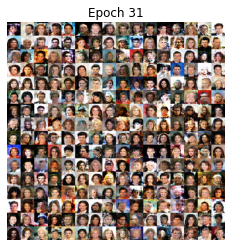

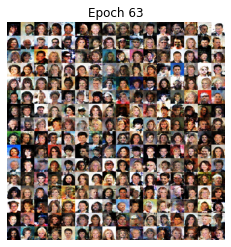

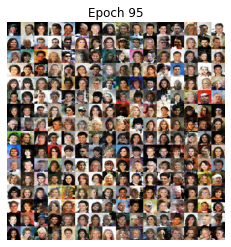

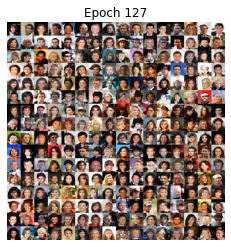

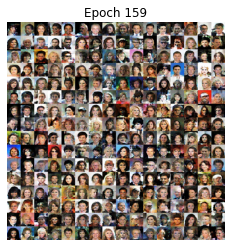

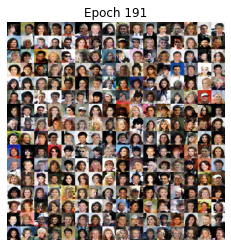

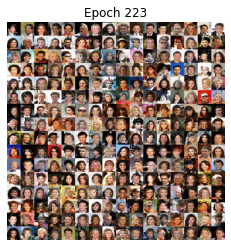

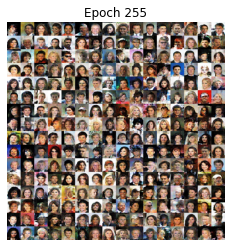

In [11]:
wlg = [None] * W_EPOCH
wld = [None] * W_EPOCH
wsp = [None] * W_EPOCH
rsTrain = float(BATCH_SIZE) / float(len(dsTrain))
ctr = 0
for ep in range(W_EPOCH):
    lgt = 0.0
    ldt = 0.0
    for c1 in dsTrain:
        lg, ld = WTrain[ctr](c1)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == WCritic : ctr = 0
    wlg[ep] = lgt * rsTrain
    wld[ep] = ldt * rsTrain
    
    out = WG(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "imgs/w_%04d.png" % ep
    )
    wsp[ep] = img
    
    checkpoint.save(file_prefix = checkpoint_prefix)
    if (ep+1) % 32 == 0:     
        plt.imshow(img)
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()

In [12]:
utMakeGif(np.array(wsp[:W_EPOCH]), "imgs/iwgan.gif", duration = 2)

t:   1%|          | 2/256 [00:00<00:14, 17.79it/s, now=None]

MoviePy - Building file imgs/iwgan.gif with imageio.


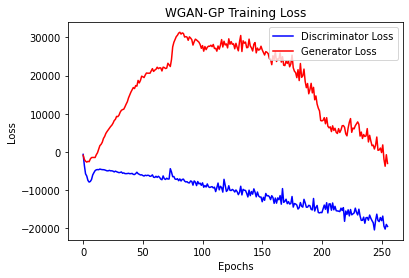

In [13]:
plt.plot(range(W_EPOCH), wld, color = "blue", label = "Discriminator Loss")
plt.plot(range(W_EPOCH), wlg, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN-GP Training Loss")
plt.show()

# GIF連結:
https://drive.google.com/file/d/1GLWV-JHkOsITI7zFnviePX39JqWYqP1U/view?usp=sharing

# report
## 前處理部分，我只有把圖片load出來，做成dataset而已
## 實作演算法部份，就直接實現出psudo code，並沒有做什麼特別改變
## 最後結果，發現generator loss比 Discriminator高，不知道有沒有錯誤